In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sympy import *

In [2]:
# user defined parameters
u = 2 # velocity
#Tf = 0.5 
Tf=2 # final time
ax = -1; bx = 1
sigma = 1/8
#qinit = lambda x: np.exp(-(x/(2*sigma))**2)
qinit = lambda x : np.sin(2*np.pi*x)
# numerical parameters


# function f(q(x,t)) = u*q(x,t)

fe = lambda q: u*q


# Numerical Parameters

In [3]:
N = 2  # order of the legendre polynomial
Q = 3
Ne = 160
Np = N*Ne + 1
a = 0.1  # CFL number

In [4]:
def Lobatto_deriv(Q, x):
    F = [] # array containing the polynomials
    dF = []
    ddF = []


    f0 = 1; F.append(f0)  # first polynomial
    df0 = 0; dF.append(df0)
    f1 = x; F.append(f1)  # second polynomial
    df1 = 1; dF.append(df1)
    ddF = [0,0]

    B = []
    dB = []


    for i in range(2, Q+1):
        fi = ((2*i-1)/i)*x*F[i-1] - ((i-1)/i)*F[i-2]  # iteration of the polynomials
        dfi = i*F[i-1] + x*dF[i-1]                    # first derivative
        F.append(fi)
        dF.append(dfi)
        ddfi = (i+1.0)*dF[i-1] + x*ddF[i-1]           # second derivative
        ddF.append(ddfi)

        bi = (1.0-x**2)*dF[i-1]                       # lobatto polynomial
        dbi = -2.0*x*dF[i-1] + (1.0-x**2)*ddF[i-1]    # derivative of lobatto polynomial
        B.append(bi)
        dB.append(dbi)
        
    return B[-1], dB[-1]

In [5]:
def Legendre_deriv(Q, x):
    L = [] # array containing the polynomials
    dL = []


    f0 = 1; L.append(f0)  # first polynomial
    df0 = 0; dL.append(df0)
    f1 = x; L.append(f1)  # second polynomial
    df1 = 1; dL.append(df1)
    

    for i in range(2, Q+1):
        fi = ((2*i-1)/i)*x*L[i-1] - ((i-1)/i)*L[i-2]  # iteration of the polynomials
        dfi = i*L[i-1] + x*dL[i-1]
        L.append(fi)
        dL.append(dfi)
        
    return L[-1], dL[-1]

In [6]:
def Lobatto_p(Q):
    X = []  # Array that contains legendre points
    K = 100  # Order of approximation of Newton method
    e = 10**(-20) #error
    for i in range(0, Q+1):
        xi0 = math.cos(((2*i+1)/(2*Q+2))*np.pi)   # Chebchev points
        

        xik = xi0

        for k in range(0, K):
            out1, out2 = Lobatto_deriv(Q+1, xik)
            xikk = xik - out1/out2   # approximation of the solution using Newton

            if abs(xikk-xik) < e:

                break

            xik = xikk

        X.append(xikk)
    return X

In [7]:
def LagrangeBasis(N, i, xl, Xr):
    
    L = 1
    dL = 0
        
    for j in range(N+1):
            
        prod = 1
        
        if (j != i):
            L = L*(xl-Xr[j])/(Xr[i]-Xr[j])
                
            for k in range(N+1):
                if (k!=i  and k!=j):
                    prod = prod*(xl-Xr[k])/(Xr[i]-Xr[k])
        
            dL = dL+prod/(Xr[i]-Xr[j])
    return L, dL

## Array intma

In [8]:
def intma(e, N):
    t = (e-1)*N
    r = N*e
    intmm = []
    for s in range(t, r+1):
        intmm.append(s)
    
    return np.array(intmm)


## Weight values

In [9]:
#funtion that compute weight values based on quadrature rule
def weight(Q):
    xi = Lobatto_p(Q)
    w = np.zeros(Q+1)
    for i in range(Q+1):
        out1, out2 = Legendre_deriv(Q, xi[i])
        w[i] = 2/(Q*(Q+1)*(out1)**2)
        
    return w 
#weight(Q)

## Element mass matrix

In [10]:
Me = np.zeros((N+1, N+1))       # initialisation of the matrix
Xr = Lobatto_p(N)               # roots
Xi = Lobatto_p(Q)               # Lobatto points
w = weight(Q)                   # weight values

for i in range(N+1):
    
    for j in range(N+1):
        for k in range(Q+1):
            xi, a1 = LagrangeBasis(N, i, Xi[k], Xr)
            xj, a2 = LagrangeBasis(N, j, Xi[k], Xr)
            Me[i,j] = Me[i,j]+ w[k]*xi*xj

           
        
Me = (1/2)*Me
         
Me = Matrix(Me)
#Me

## Global mass matrix

In [11]:
def GMM(Me, intma):
    
    M = np.zeros((Np, Np))
    
    for e in range(1,Ne+1):
        for j in range(N+1):
            
            J = intma(e, N)[j]
            
            for i in range(N+1):
                
                I = intma(e, N)[i]
                
                M[I,J] = M[I,J] + ((bx-ax)/Ne)*Me[i,j]
    return M
MM = GMM(Me, intma)


## Differential element matrix

In [12]:
De = np.zeros((N+1, N+1))
Xi = Lobatto_p(N)
w = weight(N)

for i in range(N+1):
    
    for j in range(N+1):
        for k in range(N+1):
            xi, a1 = LagrangeBasis(N, i, Xi[k], Xi)
            a2, xj = LagrangeBasis(N, j, Xi[k], Xi)
            De[i,j] = De[i,j]- w[k]*xi*xj

#De

In [13]:

# function to compute global residual vector
Miv = np.linalg.inv(MM)          #inverse of global mass matrix

def Resi(q, Miv):
    
    fe = lambda q: u*q
    
    R = np.zeros(Np)                 # global residual vector
    
    
    for e in range(1, Ne+1):         # element loop

        # discretizing into element 

        Ie  = intma(e, N)
        
        # discretizing into element 
        
        qe = q[Ie]
               
        # residual for each element
        
        # residual for each element

        Re = np.zeros(N+1)

        for i in range(N+1):
            for j in range(N+1):

                Re[i] = Re[i] - De[i,j]*fe(qe[j])

            # compuataion of global residual vector

            I = intma(e,N)[i]            

            R[I] = R[I] + Re[i]
    
    # reinitialisation of the global residual vector using inverse mass matrix
    
    GR = np.zeros(Np) 
    
    for I in range(Np):
        
        for J in range(Np):
            GR[I] = GR[I] + Miv[I,J]*R[J]
          
    return GR

In [14]:
# spatial stuff

x = np.linspace(-1, 1, Np)

q0 = qinit(x)         # defined initial condition
dx = (bx-ax)/(Np-1)   # for second order

#time stuff


dtest = a*dx/np.abs(u)
M = Tf//dtest+1
M = int(M)
t = np.linspace(0, Tf, M+1)
dt = Tf/M
# initial condition
print(M)

# array that contains the solutions
q = {}

# Boundary conditions

q0[0] = qinit(ax) 
q0[-1] = qinit(bx) 

q[0] = q0


# computation of the solution of 1D wave equation

for n in range(M):                   # time loop
    
    GR1 = Resi(q[n], Miv)
        
    # soultion for the wave equation at time n+1
    
    qh = q[n] + (dt/2)*GR1
    
    GR2 = Resi(qh, Miv)
    
    q[n+1] = q[n] + dt*GR2 
    
    q[n+1][0] = qinit(ax-u*t[n+1])
    q[n+1][-1] = qinit(bx-u*t[n+1])
dt

6400


0.0003125

# Runge Kunta

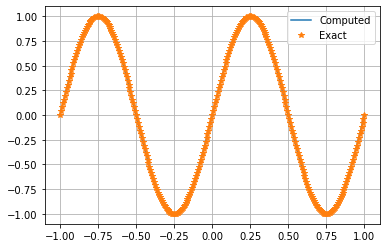

In [15]:
s = M
plt.plot(x, q[s], label = 'Computed')
plt.plot(x, qinit(x-u*t[s]),'*', label = 'Exact')
plt.legend()
plt.grid()

# Error

In [16]:
error = np.abs(q[s]-qinit(x-u*t[s]))
error_max=np.max(error)
error_max

0.0003890417306314786

In [17]:
M

6400

In [18]:
Lobatto_p(8)

[1.0,
 0.8997579954114601,
 0.6771862795107377,
 0.36311746382617816,
 0.0,
 -0.36311746382617816,
 -0.6771862795107377,
 -0.8997579954114601,
 -1.0]

In [19]:
# spatial stuff

x = np.linspace(-1, 1, Np)

q0 = qinit(x)         # defined initial condition
dx = (bx-ax)/(Np-1)   # for second order

#time stuff



dtest = a*dx/np.abs(u)
M = Tf//dtest+1
M = int(M)
t = np.linspace(0, Tf, M+1)
dt = Tf/M
# initial condition
print(M)

# array that contains the solutions
q = {}

# Boundary conditions

q0[0] = qinit(ax) ; q0[-1] = qinit(bx) 

q[0] = q0

#inverse of global mass matrix

Miv = np.linalg.inv(MM)

# computation of the solution of 1D wave equation

for n in range(M):                   # time loop
    
    R = np.zeros(Np)                 # global residual vector
    
    for e in range(1, Ne+1):         # element loop
        
        Ie  = intma(e, N)
        
        # discretizing into element 
        
        qe = q[n][Ie]
               
        # residual for each element
        
        Re = np.zeros(N+1)
        
        for i in range(N+1):
            for j in range(N+1):
                
                Re[i] = Re[i] - De[i][j]*fe(qe)[j]
               
            # compuataion of global residual vector
            
            I = intma(e,N)[i]            
            
            R[I] = R[I] + Re[i]      
            
    # reinitialisation of the global residual vector using inverse mass matrix
    
    RR = np.zeros(Np) 
    
    for I in range(Np):
        
        for J in range(Np):
            
            RR[I] = RR[I] + Miv[I][J]*R[J]
    
    # soultion for the wave equation at time n+1
    
    q[n+1] = q[n] + dt*RR 
    
    q[n+1][0] = qinit(ax-u*t[n+1])
    q[n+1][-1] = qinit(bx-u*t[n+1])
    
print(M)

6400


KeyboardInterrupt: 